# Goal:
This notebook aims to provide an exploratory data analysis on the measurements of water storage and discharge from the [Three Gorges Dam](https://maps.app.goo.gl/njteXydsd6j75Cki8) in Yichang, Hubei, China. Forecasts of upstream water levels in the dam will also be performed using an MLP- and LSTM-based machine learning models. Forecasting performance will also be analyzed.

<a id="fig1"></a>![scrsht1](scrsht1.jpg)
**Figure 1.** Cross-sectional image of a dam. Image sourced from [[1](https://vincivilworld.com/2022/10/17/components-of-dam-functions/)]

## What are dams?
Dams are structures built across a stream or river to hold water back and are often used to store water, generate electricity, and control flooding [[2](https://education.nationalgeographic.org/resource/dams/)]. **Upstream** (see Figure [1](#fig1)) is the side of the dam barrier where the water is stored; it is typically called a reservoir. Note that it is on this side where the gravitational potential energy is stored due to its height from the ground. On the other hand, the **downstream** is the side of the water where water flows out. Water released downstream usually flows into a river (or any body of water), with which it can be used for irrigation, water supply, or industrial use.

## The Three Gorges Water Dam
The Three Gorges water dam (**TGD**, coordinates: 30°49′23″N 111°00′12″E, see Figure [2](threeGorgesDamLocation.jpeg)), built on the Yangtze River (Chang Jiang), is one of the largest irrigation and hydroelectric engineering projects in the world. The TGD is 185 m high and 2.3 km long, has a water storage capacity of 39.3 billion cubic meters [[4](https://www.biodiversity-science.net/EN/abstract/abstract7136.shtml)], and is predominantly made of concrete and steel.

While the body of the dam was completed in 2006, the power plant became fully operational in 2012 [[5](https://web.archive.org/web/20130512233812/http://www.ctg.com.cn/xwzx/news.php?mnewsid=60653)]. The TGD comprises 32 main turbines, each of which having a capacity of 700 MW [[6](https://web.archive.org/web/20090209230355/http://www.ctgpc.com.cn/sx/news.php?mNewsId=30559)]. It also has two small 50 MW turbines that are used to power the plant itself [[7](https://eandt.theiet.org/2009/03/02/taming-yangtze)].


![threeGorgesDamLocation](threeGorgesDamLocation.jpeg)

**Figure 2.** The location of the Three Gorges water dam in Hubei, China. Image taken from [[3](https://images.newscientist.com/wp-content/uploads/1995/01/19624101.jpg)].




## TGD dataset
The dataset, sourced from [[8](https://www.kaggle.com/datasets/konivat/three-gorges-dam-water-data)], lays out the measurements of water storage and discharge from the TGD from 17 April 2011 to 30 Apr 2021, or approximately 10 years.

# PART 1: DATA CLEANING


## Import the necessary libraries
Note that if a library hasn't been installed in your system, `pip3 install <library>` works in most cases. Otherwise, I hope you find this [link](https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/) useful.

In [1]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno as msno # if not installed, install it using: pip3 install missingno
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.figure_factory as ff
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, ccf
from scipy.signal import find_peaks
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense

seedNum = 1001

import warnings
warnings.filterwarnings("ignore")

2024-04-15 02:41:18.350464: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# load the water level data
dataWS= pd.read_csv('data/threegorges-water-storage.csv')
dataWS.head()

,measurement_date,upstream_water_level,downstream_water_level,inflow_rate,outflow_rate
0,2011 Apr 17,159.94,64.82,6500.0,7490.0
1,2011 Apr 18,159.62,65.20,6100.0,8070.0
2,2011 Apr 19,159.30,64.85,5800.0,8100.0
3,2011 Apr 20,158.94,64.58,5800.0,8080.0
4,2011 Apr 21,158.70,65.14,6600.0,8140.0


To give a close look on the data, we plot using plotly.

In [3]:
# Convert measurement_date to datetime
dataWS['measurement_date'] = pd.to_datetime(dataWS['measurement_date'])

# Create subplots
fig = make_subplots(rows=4, cols=1, shared_xaxes=True,
                    subplot_titles=("Upstream Water Level", "Downstream Water Level", "Inflow Rate", "Outflow Rate"))

# Upstream Water Level
fig.add_trace(go.Scatter(x=dataWS['measurement_date'], y=dataWS['upstream_water_level'],
                         mode='lines', name='Upstream Water Level'), row=1, col=1)

# Downstream Water Level
fig.add_trace(go.Scatter(x=dataWS['measurement_date'], y=dataWS['downstream_water_level'],
                         mode='lines', name='Downstream Water Level'), row=2, col=1)

# Inflow Rate
fig.add_trace(go.Scatter(x=dataWS['measurement_date'], y=dataWS['inflow_rate'],
                         mode='lines', name='Inflow Rate'), row=3, col=1)

# Outflow Rate
fig.add_trace(go.Scatter(x=dataWS['measurement_date'], y=dataWS['outflow_rate'],
                         mode='lines', name='Outflow Rate'), row=4, col=1)

# Update layout
fig.update_layout(height=800, width=700,
                  font=dict(size=9))

# Update xaxis properties for the last subplot only
fig.update_xaxes(title_text="Measurement Date", row=4, col=1, tickangle=-45,
                 tickmode="array",
                 tickvals=dataWS['measurement_date'].dt.year.drop_duplicates().apply(lambda x: pd.Timestamp(year=x, month=1, day=1)),
                 ticktext=dataWS['measurement_date'].dt.year.drop_duplicates().astype(str))

# Update yaxis titles
fig.update_yaxes(title_text="Upstream Water Level (m)", row=1, col=1)
fig.update_yaxes(title_text="Downstream Water Level (m)", row=2, col=1)
fig.update_yaxes(title_text="Inflow Rate (m³/s)", row=3, col=1)
fig.update_yaxes(title_text="Outflow Rate (m³/s)", row=4, col=1)
fig.show()

Notice that in downstream water level, the measurement dropped to about 40 m on 2021 Feb 6 and continued that way until the latest date in the dataset.

Let us take a peek at the unique values per column and if there are null values.

In [4]:
dataWS_info = pd.DataFrame(dataWS.dtypes, columns=['Dtype'])
dataWS_info['Unique'] = dataWS.nunique().values
dataWS_info['Null'] = dataWS.isnull().sum().values
dataWS_info

,Dtype,Unique,Null
measurement_date,datetime64[ns],3667,0
upstream_water_level,float64,1828,127
downstream_water_level,float64,623,144
inflow_rate,float64,318,127
outflow_rate,float64,713,127


From the table above, all columns but `measurement_date` are floats. However, those columns contain null elements. 

Let's check if there are duplicated values.

In [5]:
dataWS.duplicated().sum()

0

No duplicated elements!

## Dealing with missing values

As mentioned, float-based columns `upstream_water_level`, `downstream_water_level`, `inflow_rate`, and `outflow_rate` have missing values. Let's check what those values are and in which dates.

In [6]:
missingData = dataWS.isnull()
missingFields = []

# Iterate over the dataframe to find missing data points and their corresponding dates
for index, row in missingData.iterrows():
    for col in missingData.columns:
        if row[col]:
            missingFields.append({"date": dataWS.at[index, "measurement_date"], "column": col})

# Convert the list of dictionaries into a DataFrame
missingFields_DF = pd.DataFrame(missingFields)

missingFields_DF

,date,column
0,2011-07-27,upstream_water_level
1,2011-07-27,downstream_water_level
2,2011-07-27,inflow_rate
3,2011-07-27,outflow_rate
4,2011-07-28,upstream_water_level
...,...,...
520,2021-02-28,outflow_rate
521,2021-03-01,upstream_water_level
522,2021-03-01,downstream_water_level
523,2021-03-01,inflow_rate


I recently found one pretty way to visualize null entries. Cue in **missingno** [[9](https://github.com/ResidentMario/missingno)]. 

<Axes: >

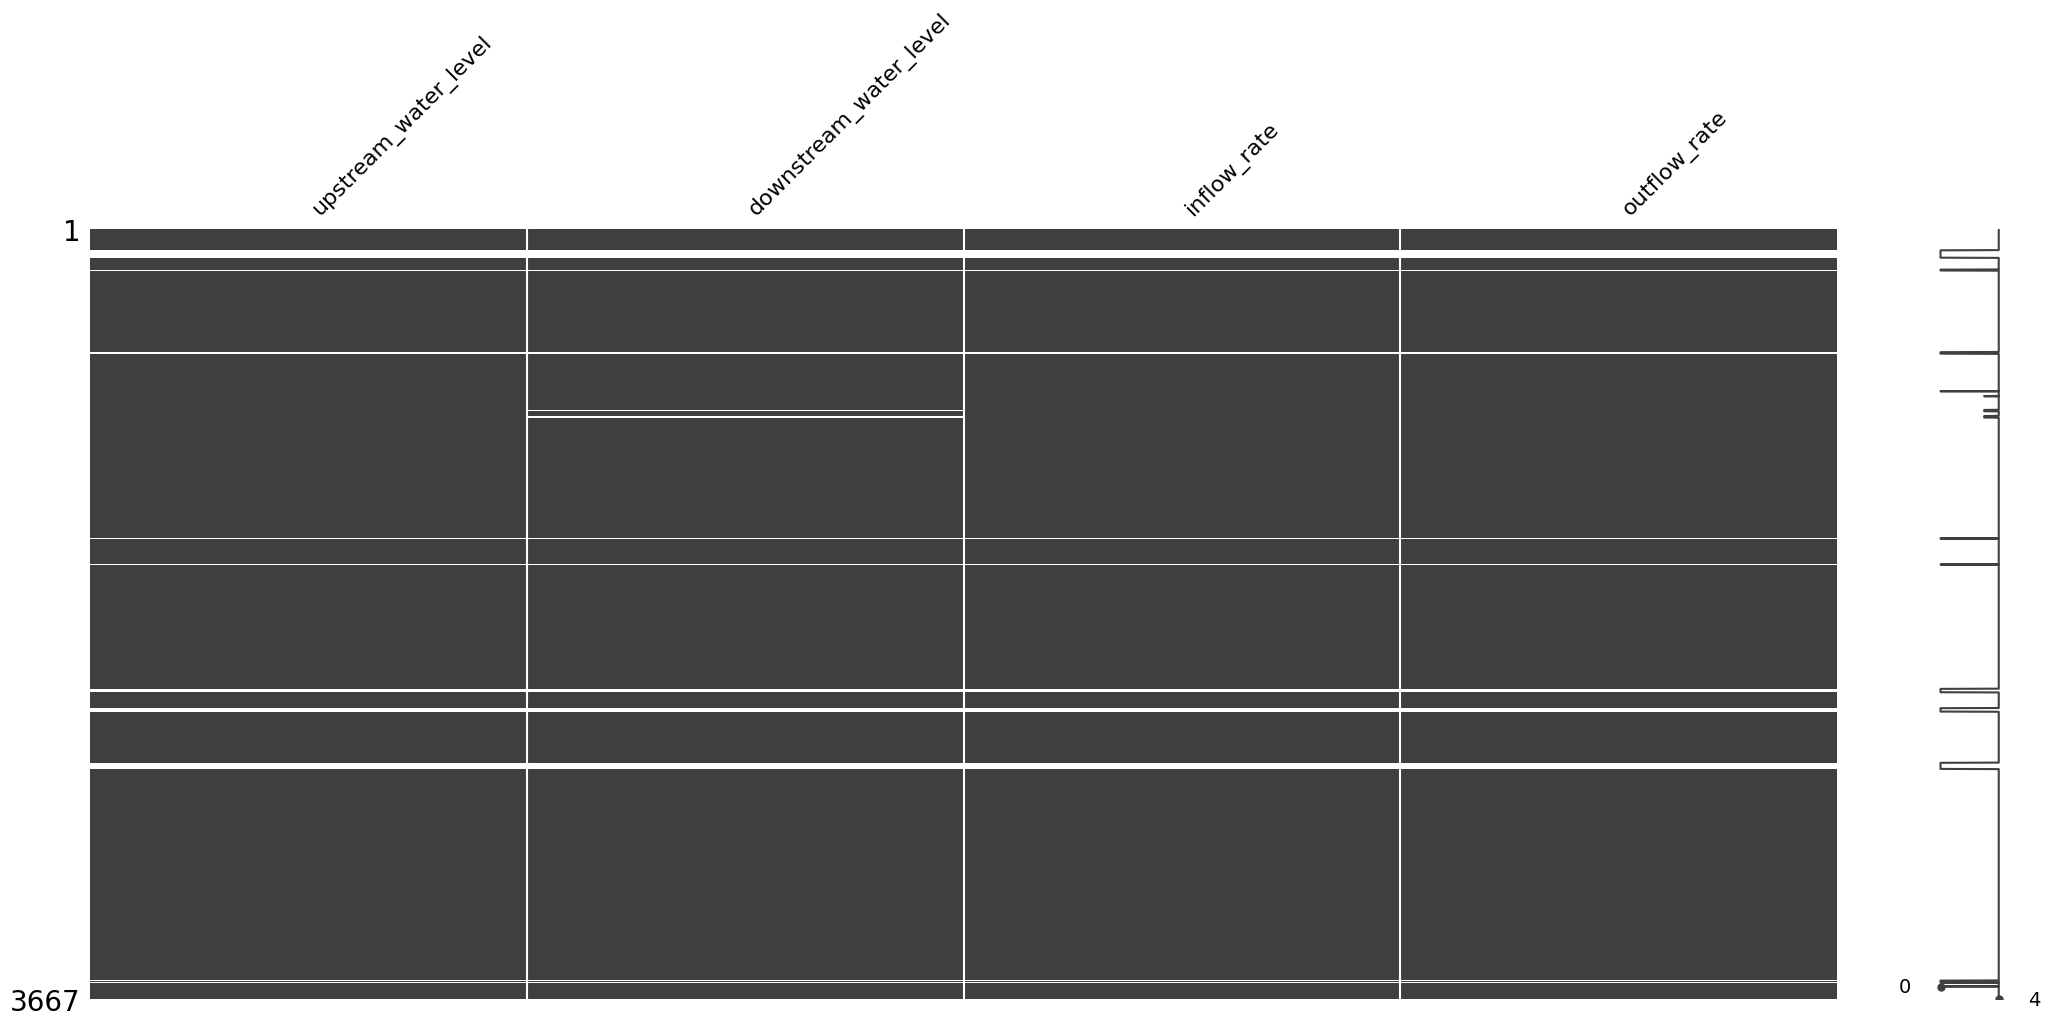

In [7]:
# Select columns to be normalized
columns_to_normalize = ['upstream_water_level', 'downstream_water_level', 'inflow_rate', 'outflow_rate']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the selected columns and update in dataWS
dataWS_viz = dataWS.copy()
dataWS_viz.set_index(dataWS_viz['measurement_date'],inplace=True)
dataWS_viz.drop(columns=['measurement_date'],inplace=True)
dataWS_viz[columns_to_normalize] = scaler.fit_transform(dataWS_viz[columns_to_normalize])

# Visualize the missing elements
msno.matrix(dataWS_viz)

Based on this visualization, majority of the missing entries happen on specific dates on ALL columnns (except `measurement_date`).

In [8]:
## AI prompt: "get the value counts of the missing elements per column"
missingFields_DF['column'].value_counts()

column
downstream_water_level    144
upstream_water_level      127
inflow_rate               127
outflow_rate              127
Name: count, dtype: int64

Now that we have these missing values, what we'll do is to do **imputation**. Data imputation is a technique used to handle missing values in a dataset by replacing them with non-missing values like the mean of the available values in the same column [[10](https://dataheroes.ai/glossary/data-imputation/)].

In [9]:
# Select only the float columns for imputation
float_columns = dataWS.select_dtypes(include=['float64']).columns

# Initialize the SimpleImputer to use mean for imputation
imputer = SimpleImputer(strategy='mean')

# Apply the imputer to the selected columns
dataWS_imputed = dataWS.copy()
dataWS_imputed['measurement_date'] = dataWS['measurement_date']
dataWS_imputed[float_columns] = imputer.fit_transform(dataWS_imputed[float_columns])


dataWS_imputed.head()

,measurement_date,upstream_water_level,downstream_water_level,inflow_rate,outflow_rate
0,2011-04-17,159.94,64.82,6500.0,7490.0
1,2011-04-18,159.62,65.20,6100.0,8070.0
2,2011-04-19,159.30,64.85,5800.0,8100.0
3,2011-04-20,158.94,64.58,5800.0,8080.0
4,2011-04-21,158.70,65.14,6600.0,8140.0


Data imputation is complete! Now, let's visualize the imputed dataset.

In [10]:

# Convert measurement_date to datetime
dataWS_imputed['measurement_date'] = pd.to_datetime(dataWS_imputed['measurement_date'])

# Create subplots
fig_imputed = make_subplots(rows=4, cols=1, shared_xaxes=True,
                    subplot_titles=("Upstream Water Level", "Downstream Water Level", "Inflow Rate", "Outflow Rate"))

# Upstream Water Level
fig_imputed.add_trace(go.Scatter(x=dataWS_imputed['measurement_date'], y=dataWS_imputed['upstream_water_level'],
                         mode='lines', name='Upstream Water Level'), row=1, col=1)

# Downstream Water Level
fig_imputed.add_trace(go.Scatter(x=dataWS_imputed['measurement_date'], y=dataWS_imputed['downstream_water_level'],
                         mode='lines', name='Downstream Water Level'), row=2, col=1)

# Inflow Rate
fig_imputed.add_trace(go.Scatter(x=dataWS_imputed['measurement_date'], y=dataWS_imputed['inflow_rate'],
                         mode='lines', name='Inflow Rate'), row=3, col=1)

# Outflow Rate
fig_imputed.add_trace(go.Scatter(x=dataWS_imputed['measurement_date'], y=dataWS_imputed['outflow_rate'],
                         mode='lines', name='Outflow Rate'), row=4, col=1)

# Update layout
fig_imputed.update_layout(height=800, width=700,
                  title_text="Three Gorges Dam Water Data",
                  font=dict(size=9))

# Update xaxis properties for the last subplot only
fig_imputed.update_xaxes(title_text="Measurement Date", row=4, col=1, tickangle=-45,
                 tickmode="array",
                 tickvals=dataWS_imputed['measurement_date'].dt.year.drop_duplicates().apply(lambda x: pd.Timestamp(year=x, month=1, day=1)),
                 ticktext=dataWS_imputed['measurement_date'].dt.year.drop_duplicates().astype(str))

# Update yaxis titles
fig_imputed.update_yaxes(title_text="Upstream Water Level (m)", row=1, col=1)
fig_imputed.update_yaxes(title_text="Downstream Water Level (m)", row=2, col=1)
fig_imputed.update_yaxes(title_text="Inflow Rate (m³/s)", row=3, col=1)
fig_imputed.update_yaxes(title_text="Outflow Rate (m³/s)", row=4, col=1)

fig_imputed.show()

Let's check the imputed dataset for null values.

In [11]:
dataWS_imputed_info = pd.DataFrame(dataWS_imputed.dtypes, columns=['Dtype'])
dataWS_imputed_info['Unique'] = dataWS_imputed.nunique().values
dataWS_imputed_info['Null'] = dataWS_imputed.isnull().sum().values
dataWS_imputed_info

,Dtype,Unique,Null
measurement_date,datetime64[ns],3667,0
upstream_water_level,float64,1829,0
downstream_water_level,float64,624,0
inflow_rate,float64,319,0
outflow_rate,float64,714,0


No more missing values!

# PART 2. EXPLORATORY DATA ANALYSIS

Let's take a look at the distribution of each of the columns in the water level dataset.

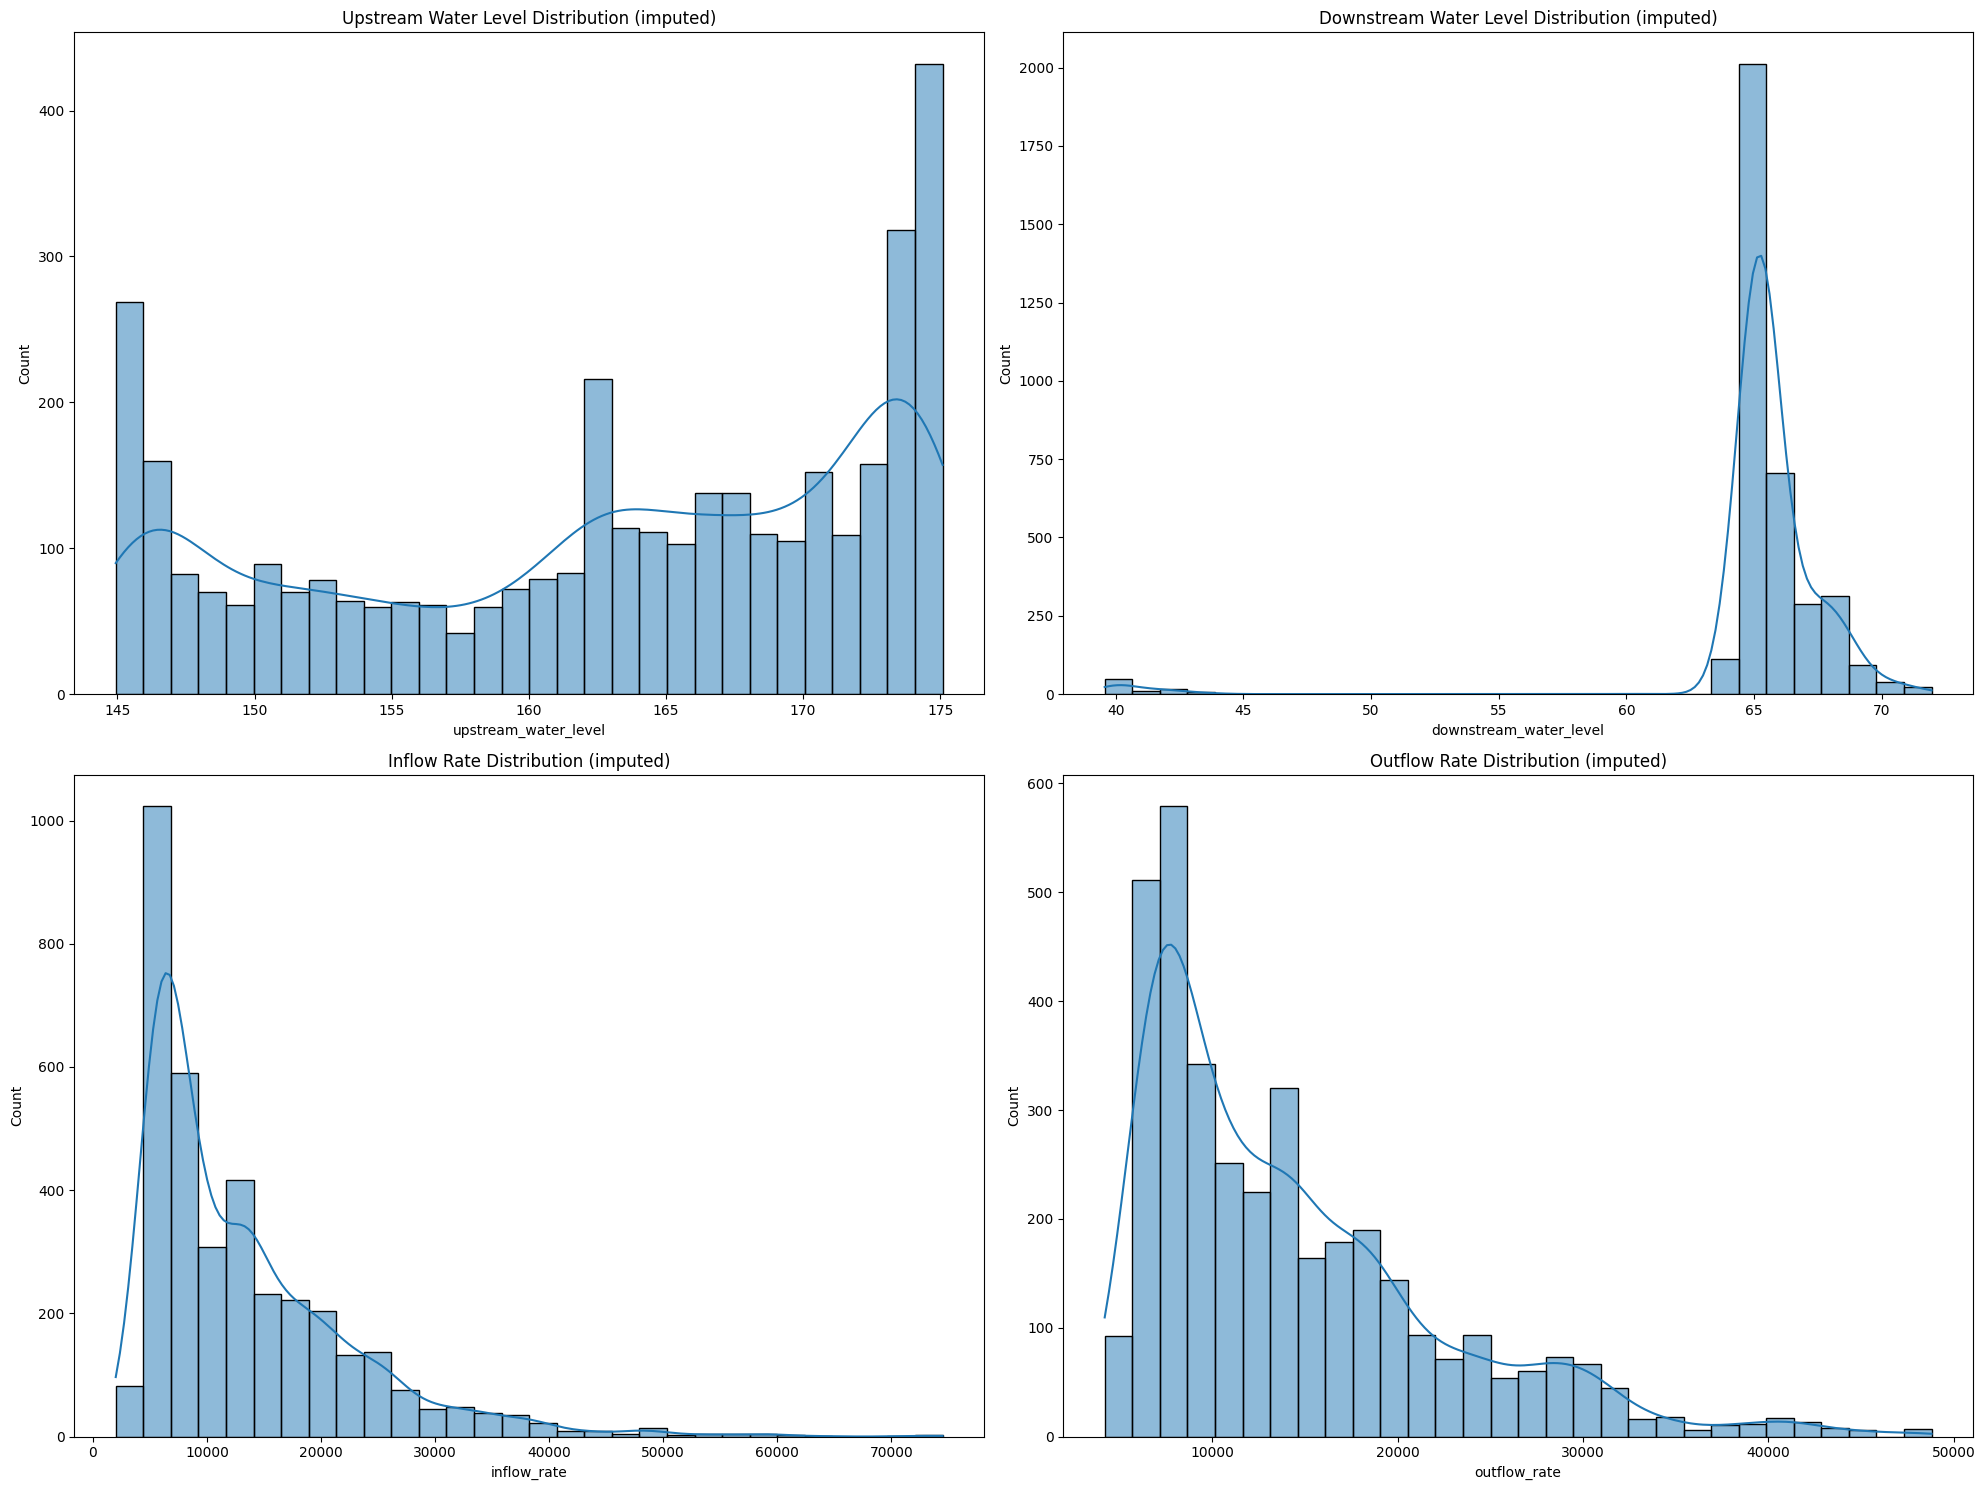

In [12]:
# Use .describe() to extract statistical variables for each column in the imputed data
upstream_stats_imputed = dataWS_imputed['upstream_water_level'].describe()
downstream_stats_imputed = dataWS_imputed['downstream_water_level'].describe()
inflow_rate_stats_imputed = dataWS_imputed['inflow_rate'].describe()
outflow_rate_stats_imputed = dataWS_imputed['outflow_rate'].describe()


# Distribution of each numerical feature in the imputed data
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
sns.histplot(dataWS_imputed['upstream_water_level'], kde=True, bins=30)
plt.title('Upstream Water Level Distribution (imputed)')

plt.subplot(2, 2, 2)
sns.histplot(dataWS_imputed['downstream_water_level'], kde=True, bins=30)
plt.title('Downstream Water Level Distribution (imputed)')

plt.subplot(2, 2, 3)
sns.histplot(dataWS_imputed['inflow_rate'], kde=True, bins=30)
plt.title('Inflow Rate Distribution (imputed)')

plt.subplot(2, 2, 4)
sns.histplot(dataWS_imputed['outflow_rate'], kde=True, bins=30)
plt.title('Outflow Rate Distribution (imputed)')

plt.tight_layout()
plt.show()

## Correlation analysis

Now, let's check for any indications of correlation within the variables of the water level dataset.

In [13]:
# Calculate the correlation matrix
correlation_matrix = dataWS_imputed.drop('measurement_date', axis=1).corr()

# Convert the correlation matrix to a 2D array
matrix_values = correlation_matrix.values
labels = correlation_matrix.columns.tolist()  # Convert Index to list

# Prepare annotation texts with conditional coloring
annotation_texts = np.empty(matrix_values.shape, dtype=object)
for i in range(len(matrix_values)):
    for j in range(len(matrix_values[i])):
        if -0.2 < matrix_values[i][j] < 0.4:
            annotation_texts[i][j] = f"{matrix_values[i][j]:.2f}"
        else:
            annotation_texts[i][j] = f"{matrix_values[i][j]:.2f}"

# Create a heatmap using plotly
fig = ff.create_annotated_heatmap(
    z=matrix_values, 
    x=labels, 
    y=labels, 
    colorscale='RdBu',  # Using RdBu as the color scale
    annotation_text=annotation_texts,
    showscale=True,  # Adding a color scale
    font_colors=['black', 'white']  # Black for positive and negative values outside the range, white for values within the range
)

# Update the layout to place x labels on top and set font size
fig.update_layout(
    xaxis=dict(tickfont=dict(size=10), side='top'),  # X labels on top
    yaxis=dict(tickfont=dict(size=10)),  # Font size for both axes
)


fig.show()

Dive straight to the `upstream_water_level` part. This heatmap implies that the correlations of `upstream_water_level` with the rest of the dataset are _negative_.

## Autocorrelation analysis
Before we proceed to the modeling, note that it is critical to check for the autocorrelation function (ACF) of the target varaible `upstream_water_level`. That is, determine its lags that yield the maximum ACF aside from lag = 0.

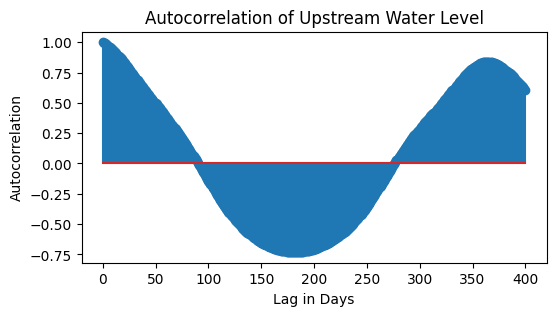

In [14]:
# Check for autocorrelation in upstream_water_level to determine optimal lags
autocorr_upstream = acf(dataWS_imputed['upstream_water_level'], nlags=400)
plt.figure(figsize=(6, 3))
plt.stem(range(len(autocorr_upstream)), autocorr_upstream)
plt.title('Autocorrelation of Upstream Water Level')
plt.xlabel('Lag in Days')
plt.ylabel('Autocorrelation')
plt.show()

To check the other peak aside from lag 0, we use `scipy.signal`'s `find_peaks`.

In [15]:
peaks_,_ = find_peaks(autocorr_upstream)
print(peaks_[-1])

364


The result and the plot above show that `upstream_water_level` has an **annual seasonality**.

## Cross-correlation
Aside from the autocorrelation of `upstream_water_level`, cross-correlations between `upstream_water_level` and the rest of the variables will also be probed.

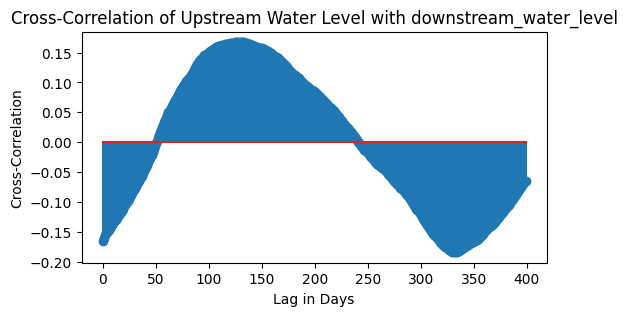

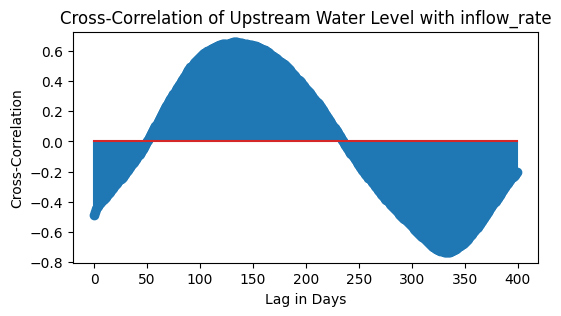

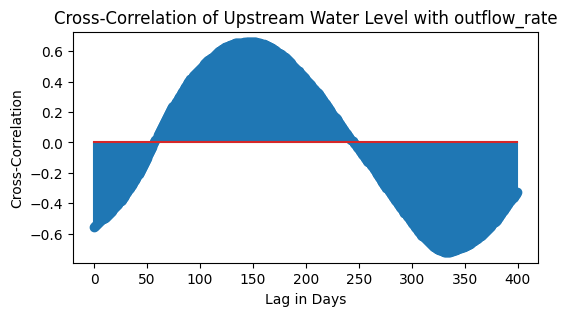

In [16]:
# Check for cross-correlation to determine optimal lags with other features
features = ['downstream_water_level', 'inflow_rate', 'outflow_rate']
for feature in features:
    cross_corr = ccf(dataWS_imputed['upstream_water_level'], dataWS_imputed[feature], unbiased=True)[:400]
    plt.figure(figsize=(6, 3))
    plt.stem(range(len(cross_corr)), cross_corr)#, use_line_collection=True)
    plt.title(f'Cross-Correlation of Upstream Water Level with {feature}')
    plt.xlabel('Lag in Days')
    plt.ylabel('Cross-Correlation')
    plt.show()

Similar to the ACF, we determine the peaks of the cross-correlation functions and _temporarily assume_ that in the event of more than one peak, the **last** value will be considered.

In [17]:
# maxlag = 365 will be used given the annual seasonality of `upstream_water_level`
maxlag = 365
dictCCF = {}
for i in ['downstream_water_level', 'inflow_rate', 'outflow_rate']:
    crossCorr = ccf(dataWS_imputed['upstream_water_level'], dataWS_imputed[i], unbiased=True)[:maxlag]
    peaks,_ = find_peaks(crossCorr)
    dictCCF.update({i:peaks[-1]})
print(dictCCF)

{'downstream_water_level': 132, 'inflow_rate': 132, 'outflow_rate': 148}


# PART 3: ML modeling
For this part, we will be developing a machine learning model that will take in lagged values of `upstream_water_level` (at lag=365 d), `downstream_water_level` (at lag=132 d), `inflow_rate` (at lag=132 d), and `outflow_rate` (at lag=148 d). 

Training and test sets will be formed from the dataset with test set ratio of 20 percent. Furthermore, `sklearn`'s `MinMaxScaler` will be used to transform the training test.

## MLP model
In this notebook, the MLP is assumed to have 100 hidden units and ReLu activation. Adam optimizer is used during training.  The performance of the MLP model will be checked by plotting the predicted and actual values from the test set and calculating the $R^{2}$ of the best-fit line.

In [18]:
dataWS_ml = dataWS_imputed.copy()
dataWS_ml = dataWS_ml.drop(columns=['measurement_date'])


dataWS_ml[f'upstream_water_level_t-{365}'] = dataWS_ml['upstream_water_level'].shift(365)

for i in ['downstream_water_level', 'inflow_rate', 'outflow_rate']:
    dataWS_ml[f'{i}_t-{dictCCF[i]}'] = dataWS_ml[i].shift(dictCCF[i])

# Drop rows with NaN values resulting from the shift operation
dataWS_ml.dropna(inplace=True)


# Define features and target
X = dataWS_ml.filter(like='t-')
y = dataWS_ml['upstream_water_level']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seedNum)

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the training data and transforming both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Initialize and train the MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500)
mlp.fit(X_train, y_train)

# Predict the test set
y_pred = mlp.predict(X_test)



In [19]:
# Calculate R2 score
r2 = r2_score(y_test, y_pred)

# Best fit line
m, b = np.polyfit(y_test, y_pred, 1)

# Create traces
trace1 = go.Scatter(
    x = y_test,
    y = y_pred,
    mode = 'markers',
    name = 'Predicted vs Actual',
    marker=dict(color='#4A99AB')
)

trace2 = go.Scatter(
    x = y_test,
    y = y_test,
    mode = 'lines',
    name = 'Identity Line (y_test=y_test)',
    line=dict(color='#FFA8F8')
)

trace3 = go.Scatter(
    x = y_test,
    y = m*y_test + b,
    mode = 'lines',
    name = f'Best Fit Line (R²={r2:.2f})',
    line=dict(color='red')
)

data = [trace1, trace2, trace3]

# Customize the layout
layout = go.Layout(
    title = 'y_test vs y_pred for MLP model',
    xaxis = dict(title = 'y_test'),
    yaxis = dict(title = 'y_pred'),
    showlegend = True
)

fig = go.Figure(data=data, layout=layout)

fig.show()

## LSTM model
The LSTM model in this notebook comprises the same features as those used in the MLP model. Additionally, this model uses an LSTM layer with 50 hidden units and followed by a dense layer. Training will be done with 10 epochs and batch_size of 100. Similar to the MLP model, the LSTM model's performance will be assessed by plotting the predicted and actual values from the test set and calculating the $R^{2}$ of the best-fit line.

In [20]:
# Scale the features
scaler = MinMaxScaler()
X_scaledLSTM = scaler.fit_transform(X)
yLSTM = y.values.reshape(-1, 1)  # Reshape the scaler
y_scaledLSTM = scaler.fit_transform(yLSTM)


# Reshaping input to be 3D [samples, time steps = 1, features] for LSTM
# note: time step => number of time intervals you look back at any given point in time for making a prediction
X_scaledLSTM = X_scaledLSTM.reshape((X_scaledLSTM.shape[0], 1, X_scaledLSTM.shape[1]))


# Split the data into training and testing sets
X_trainLSTM, X_testLSTM, y_trainLSTM, y_testLSTM = train_test_split(X_scaledLSTM, y_scaledLSTM, test_size=0.2, random_state=seedNum)

# Define the LSTM model
# for this notebook, we set number of hidden nodes to 50
# epochs = 10
# batch_size = 10
modelLSTM = Sequential()
modelLSTM.add(LSTM(100, input_shape=(X_trainLSTM.shape[1], X_trainLSTM.shape[2])))
modelLSTM.add(Dense(1))
modelLSTM.compile(loss='mae', optimizer='adam')

# Fit the model
# tip: increase the batch size to around 10^2 (if around 5, R2 of actual vs pred will be bad)
modelLSTM.fit(X_trainLSTM, y_trainLSTM, epochs=10, batch_size=100, validation_data=(X_testLSTM, y_testLSTM), verbose=2, shuffle=False)

# Predictions
yPredLSTM_scaled = modelLSTM.predict(X_testLSTM)

# Invert scaling for forecast
yPredLSTM_inv = scaler.inverse_transform(yPredLSTM_scaled)



Epoch 1/10
27/27 - 1s - 46ms/step - loss: 0.4761 - val_loss: 0.3686
Epoch 2/10
27/27 - 0s - 3ms/step - loss: 0.2573 - val_loss: 0.1486
Epoch 3/10
27/27 - 0s - 3ms/step - loss: 0.1468 - val_loss: 0.1352
Epoch 4/10
27/27 - 0s - 3ms/step - loss: 0.1355 - val_loss: 0.1258
Epoch 5/10
27/27 - 0s - 3ms/step - loss: 0.1257 - val_loss: 0.1168
Epoch 6/10
27/27 - 0s - 3ms/step - loss: 0.1163 - val_loss: 0.1079
Epoch 7/10
27/27 - 0s - 3ms/step - loss: 0.1071 - val_loss: 0.0994
Epoch 8/10
27/27 - 0s - 3ms/step - loss: 0.0988 - val_loss: 0.0923
Epoch 9/10
27/27 - 0s - 3ms/step - loss: 0.0917 - val_loss: 0.0868
Epoch 10/10
27/27 - 0s - 3ms/step - loss: 0.0865 - val_loss: 0.0845
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [22]:
yPredLSTM_inv = yPredLSTM_inv.reshape((len(yPredLSTM_inv),))


# Calculate R2 score
r2_LSTM = r2_score(y_test, yPredLSTM_inv)

# Best fit line
m_LSTM, b_LSTM = np.polyfit(y_test, yPredLSTM_inv, 1)

# Create traces
trace1_LSTM = go.Scatter(
    x = y_test,
    y = yPredLSTM_inv,
    mode = 'markers',
    name = 'Predicted vs Actual',
    marker=dict(color='#4A99AB')
)

trace2_LSTM = go.Scatter(
    x = y_test,
    y = y_test,
    mode = 'lines',
    name = 'Identity Line (y_test=y_test)',
    line=dict(color='#FFA8F8')
)

trace3_LSTM = go.Scatter(
    x = y_test,
    y = m*y_test + b,
    mode = 'lines',
    name = f'Best Fit Line (R²={r2_LSTM:.2f})',
    line=dict(color='red')
)

dataLSTM = [trace1_LSTM, trace2_LSTM, trace3_LSTM]

# Layout can be customized as needed
layoutLSTM = go.Layout(
    title = 'y_test vs yPredLSTM_inv for LSTM model',
    xaxis = dict(title = 'y_test'),
    yaxis = dict(title = 'yPredLSTM_inv'),
    showlegend = True
)

figLSTM = go.Figure(data=dataLSTM, layout=layoutLSTM)

# Show plot
figLSTM.show()

Comparing the prediction curves for MLP and LSTM models, the latter had the better $R^{2}$ of the best-fit line. 